In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
METHODS = ['scr', 'er']
AUGMENTATION = ['none', 'ocm']
EPOCHS = [f"epoch{i+1}" for i in range(8)]
RUNS = [f"run_{i:02d}" for i in range(4)]

In [50]:
base_dir = './outputs'
folders = []
csv_file_paths = []

for root, _, files in os.walk(base_dir, followlinks=True):
    for file in files:
        if file == 'task_accs_table.csv' and 'epoch' in root:
            folders.append(root)
            csv_file_path = os.path.join(root, file)
            csv_file_paths.append(csv_file_path)

# 5 * 8 * 4 = 160
print(len(csv_file_paths))
# for i, csv_file_path in enumerate(sorted(csv_file_paths)):
#     print(f"{i}: \t {csv_file_path}")

386


In [51]:
CSV_DICT = {}
cnt = 0

for method in METHODS:
    CSV_DICT[method] = {}
    for aug in AUGMENTATION:
        CSV_DICT[method][aug] = {}
        for run in RUNS:
            CSV_DICT[method][aug][run] = {}
            for epoch in EPOCHS:
                for folder, csv_file_path in zip(folders, csv_file_paths):
                    if method in folder and aug in folder and run in folder and epoch in folder:
                        df = pd.read_csv(csv_file_path)
                        CSV_DICT[method][aug][run][epoch] = df

                        cnt += 1

CSV_DICT['mose'] = {}
CSV_DICT['mose']['ocm'] = {}
for run in RUNS:
    CSV_DICT['mose']['ocm'][run] = {}
    for epoch in EPOCHS:
        for folder, csv_file_path in zip(folders, csv_file_paths):
            if 'mose' in folder and run in folder and epoch in folder:
                df = pd.read_csv(csv_file_path)
                CSV_DICT['mose']['ocm'][run][epoch] = df

                cnt += 1

print(cnt)

128


In [64]:
def plot_acc_i_j(i=0, j=0):
    test_task_name  = f"task{i}"
    current_task_id = j

    er_none, er_ocm, scr_ocm, mose = {}, {}, {}, {}
    for run in RUNS:
        er_none[run] = []
        er_ocm[run] = []
        scr_ocm[run] = []
        mose[run] = []
        for epoch in EPOCHS:
            er_none_df = CSV_DICT['er']['none'][run][epoch]
            er_ocm_df  = CSV_DICT['er']['ocm'][run][epoch]
            scr_ocm_df = CSV_DICT['scr']['ocm'][run][epoch]
            mose_df = CSV_DICT['mose']['ocm'][run][epoch]

            er_none[run].append(er_none_df.iloc[current_task_id][test_task_name])
            er_ocm[run].append(er_ocm_df.iloc[current_task_id][test_task_name])
            scr_ocm[run].append(scr_ocm_df.iloc[current_task_id][test_task_name])
            mose[run].append(mose_df.iloc[current_task_id][test_task_name])

    er_none_mean = np.mean([er_none[run] for run in RUNS], axis=0)
    er_none_std = np.std([er_none[run] for run in RUNS], axis=0)
    er_ocm_mean = np.mean([er_ocm[run] for run in RUNS], axis=0)
    er_ocm_std = np.std([er_ocm[run] for run in RUNS], axis=0)
    scr_ocm_mean = np.mean([scr_ocm[run] for run in RUNS], axis=0)
    scr_ocm_std = np.std([scr_ocm[run] for run in RUNS], axis=0)
    mose_mean = np.mean([mose[run] for run in RUNS], axis=0)
    mose_std = np.std([mose[run] for run in RUNS], axis=0)


    figure = plt.figure(figsize=(6,5))
    x = np.arange(1, len(EPOCHS)+1)
    plt.plot(x, er_none_mean, linewidth=2.0,  label='er')
    plt.plot(x, er_ocm_mean,  linewidth=2.0, label='er+aug')
    plt.plot(x, scr_ocm_mean, linewidth=2.0, label='scr+aug')
    # plt.plot(x, mose_mean,    linewidth=2.0, label='mose(ours)')

    plt.fill_between(x, er_none_mean-er_none_std, er_none_mean+er_none_std, alpha=0.2)
    plt.fill_between(x, er_ocm_mean-er_ocm_std, er_ocm_mean+er_ocm_std, alpha=0.2)
    plt.fill_between(x, scr_ocm_mean-scr_ocm_std, scr_ocm_mean+scr_ocm_std, alpha=0.2)
    # plt.fill_between(x, mose_mean-mose_std, mose_mean+mose_std, alpha=0.2)

    plt.xlabel('epoch', fontdict={'size' : 18})
    plt.ylabel(f'task {i+1} accuracy (%)', fontdict={'size' : 18})
    plt.xticks(x, size= 18)
    plt.yticks(size= 18)
    plt.legend(loc='best', fontsize=16, fancybox=True)
    plt.show()

In [65]:
def plot_acc_avg_j(j=0):

    current_task_id = j
    er_none, er_ocm, scr_ocm , mose = {}, {}, {}, {}

    for run in RUNS:
        er_none[run] = [0. for _ in range(len(EPOCHS))]
        er_ocm[run] = [0. for _ in range(len(EPOCHS))]
        scr_ocm[run] = [0. for _ in range(len(EPOCHS))]
        mose[run] = [0. for _ in range(len(EPOCHS))]

        for e, epoch in enumerate(EPOCHS):
            er_none_df = CSV_DICT['er']['none'][run][epoch]
            er_ocm_df  = CSV_DICT['er']['ocm'][run][epoch]
            scr_ocm_df = CSV_DICT['scr']['ocm'][run][epoch]
            mose_df = CSV_DICT['mose']['ocm'][run][epoch]

            for i in range(j+1):
                test_task_name  = f"task{i}"        

                er_none[run][e] += er_none_df.iloc[current_task_id][test_task_name] / (j+1)
                er_ocm[run][e] += er_ocm_df.iloc[current_task_id][test_task_name] / (j+1)
                scr_ocm[run][e] += scr_ocm_df.iloc[current_task_id][test_task_name] / (j+1)
                mose[run][e] += mose_df.iloc[current_task_id][test_task_name] / (j+1)

    er_none_mean = np.mean([er_none[run] for run in RUNS], axis=0)
    er_none_std = np.std([er_none[run] for run in RUNS], axis=0)
    er_ocm_mean = np.mean([er_ocm[run] for run in RUNS], axis=0)
    er_ocm_std = np.std([er_ocm[run] for run in RUNS], axis=0)
    scr_ocm_mean = np.mean([scr_ocm[run] for run in RUNS], axis=0)
    scr_ocm_std = np.std([scr_ocm[run] for run in RUNS], axis=0)
    mose_mean = np.mean([mose[run] for run in RUNS], axis=0)
    mose_std = np.std([mose[run] for run in RUNS], axis=0)

    figure = plt.figure(figsize=(6,5))
    x = np.arange(1, len(EPOCHS)+1)
    plt.plot(x, er_none_mean, linewidth=2.0,  label='er')
    plt.plot(x, er_ocm_mean,  linewidth=2.0, label='er+aug')
    plt.plot(x, scr_ocm_mean, linewidth=2.0, label='scr+aug')
    # plt.plot(x, mose_mean,    linewidth=2.0, label='mose(ours)')

    plt.fill_between(x, er_none_mean-er_none_std, er_none_mean+er_none_std, alpha=0.2)
    plt.fill_between(x, er_ocm_mean-er_ocm_std, er_ocm_mean+er_ocm_std, alpha=0.2)
    plt.fill_between(x, scr_ocm_mean-scr_ocm_std, scr_ocm_mean+scr_ocm_std, alpha=0.2)
    # plt.fill_between(x, mose_mean-mose_std, mose_mean+mose_std, alpha=0.2)

    plt.xlabel('epoch', fontdict={'size' : 18})
    plt.ylabel('average accuracy (%)', fontdict={'size' : 18})
    plt.xticks(x, size= 18)
    plt.yticks(size= 18)
    plt.legend(loc='best', fontsize=18, fancybox=True)
    plt.show()

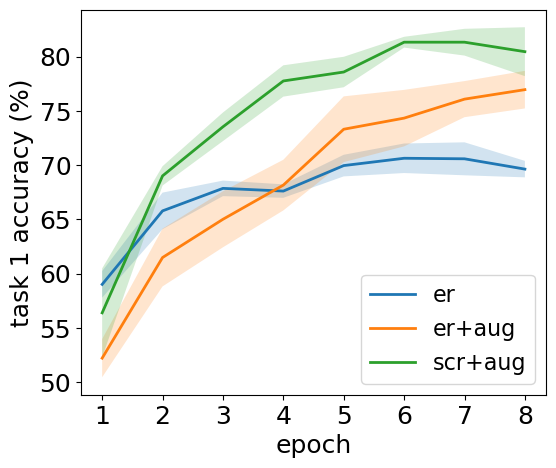

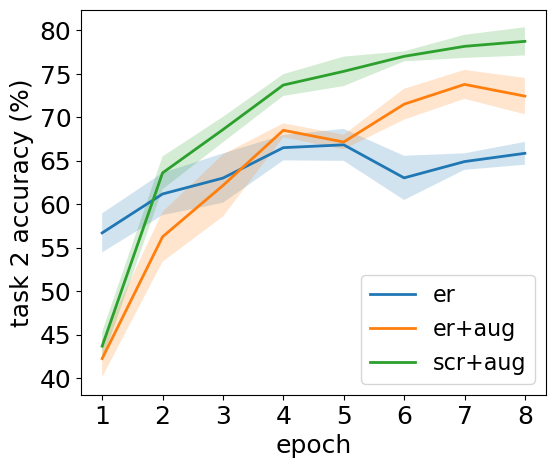

In [66]:
for j in range(2):
    # plot_acc_avg_j(j=j)
    plot_acc_i_j(i=j, j=j)

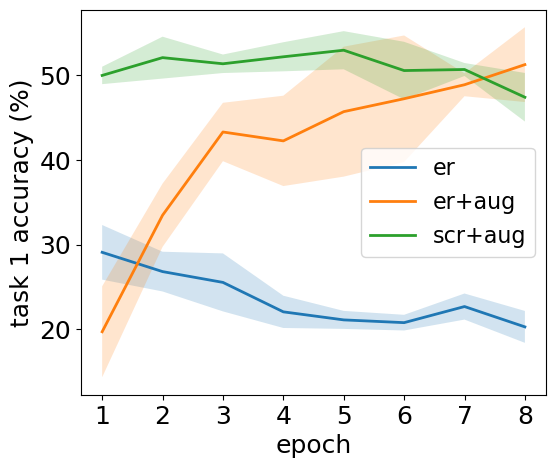

In [67]:
plot_acc_i_j(i=0, j=1)

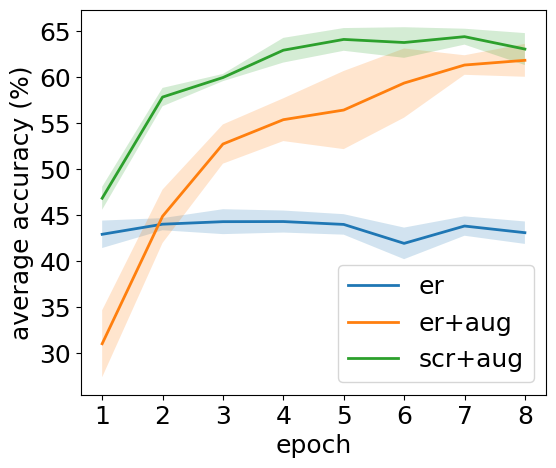

In [68]:
plot_acc_avg_j(j=1)

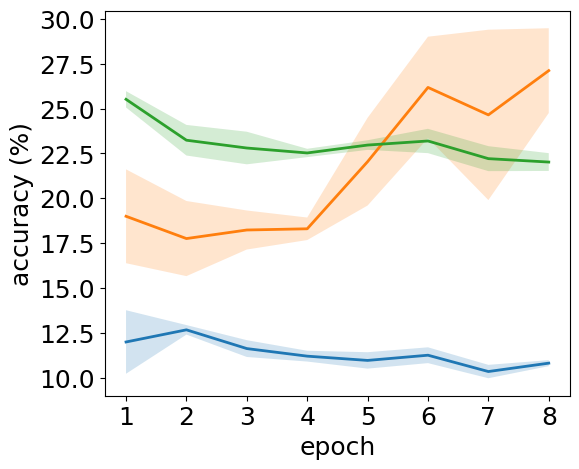

In [57]:
plot_acc_avg_j(j=9)

In [27]:
def plot_acc_avg_epoch(e=1):

    epoch = f"epoch{e}"
    er_none, er_ocm, scr_ocm, mose = {}, {}, {}, {}

    for run in RUNS:
        er_none[run] = [0. for _ in range(10)]
        er_ocm[run] = [0. for _ in range(10)]
        scr_ocm[run] = [0. for _ in range(10)]
        mose[run] = [0. for _ in range(10)]

        for j in range(10):
            er_none_df = CSV_DICT['er']['none'][run][epoch]
            er_ocm_df  = CSV_DICT['er']['ocm'][run][epoch]
            scr_ocm_df = CSV_DICT['scr']['ocm'][run][epoch]
            mose_df = CSV_DICT['mose']['ocm'][run][epoch]

            for i in range(j+1):
                test_task_name  = f"task{i}"        

                er_none[run][j] += er_none_df.iloc[j][test_task_name] / (j+1)
                er_ocm[run][j] += er_ocm_df.iloc[j][test_task_name] / (j+1)
                scr_ocm[run][j] += scr_ocm_df.iloc[j][test_task_name] / (j+1)
                mose[run][j] += mose_df.iloc[j][test_task_name] / (j+1)

    er_none_mean = np.mean([er_none[run] for run in RUNS], axis=0)
    er_none_std = np.std([er_none[run] for run in RUNS], axis=0)
    er_ocm_mean = np.mean([er_ocm[run] for run in RUNS], axis=0)
    er_ocm_std = np.std([er_ocm[run] for run in RUNS], axis=0)
    scr_ocm_mean = np.mean([scr_ocm[run] for run in RUNS], axis=0)
    scr_ocm_std = np.std([scr_ocm[run] for run in RUNS], axis=0)
    mose_mean = np.mean([mose[run] for run in RUNS], axis=0)
    mose_std = np.std([mose[run] for run in RUNS], axis=0)

    figure = plt.figure(figsize=(6,4))
    x = np.arange(1, 10+1)
    plt.plot(x, er_none_mean, linewidth=2.0,  label='er')
    plt.plot(x, er_ocm_mean,  linewidth=2.0, label='er+aug')
    plt.plot(x, scr_ocm_mean, linewidth=2.0, label='scr+aug')
    plt.plot(x, mose_mean,    linewidth=2.0, label='mose(ours)')

    plt.fill_between(x, er_none_mean-er_none_std, er_none_mean+er_none_std, alpha=0.2)
    plt.fill_between(x, er_ocm_mean-er_ocm_std, er_ocm_mean+er_ocm_std, alpha=0.2)
    plt.fill_between(x, scr_ocm_mean-scr_ocm_std, scr_ocm_mean+scr_ocm_std, alpha=0.2)
    plt.fill_between(x, mose_mean-mose_std, mose_mean+mose_std, alpha=0.2)


    plt.xlabel('task', fontdict={'size' : 15})
    plt.ylabel('accuracy (%)', fontdict={'size' : 15})
    plt.xticks(x, size= 15)
    plt.yticks(size= 15)
    plt.legend(loc='best', fontsize=15, fancybox=True)
    plt.show()

In [29]:
def plot_acc_last_epoch(e=1):

    epoch = f"epoch{e}"
    er_none, er_ocm, scr_ocm, mose = {}, {}, {}, {}

    for run in RUNS:
        er_none[run] = [0. for _ in range(10)]
        er_ocm[run] = [0. for _ in range(10)]
        scr_ocm[run] = [0. for _ in range(10)]
        mose[run] = [0. for _ in range(10)]

        for j in range(10):
            er_none_df = CSV_DICT['er']['none'][run][epoch]
            er_ocm_df  = CSV_DICT['er']['ocm'][run][epoch]
            scr_ocm_df = CSV_DICT['scr']['ocm'][run][epoch]
            mose_df = CSV_DICT['mose']['ocm'][run][epoch]

            test_task_name  = f"task{j}"

            er_none[run][j] = er_none_df.iloc[j][test_task_name]
            er_ocm[run][j] = er_ocm_df.iloc[j][test_task_name]
            scr_ocm[run][j] = scr_ocm_df.iloc[j][test_task_name]
            mose[run][j] = mose_df.iloc[j][test_task_name]

    er_none_mean = np.mean([er_none[run] for run in RUNS], axis=0)
    er_none_std = np.std([er_none[run] for run in RUNS], axis=0)
    er_ocm_mean = np.mean([er_ocm[run] for run in RUNS], axis=0)
    er_ocm_std = np.std([er_ocm[run] for run in RUNS], axis=0)
    scr_ocm_mean = np.mean([scr_ocm[run] for run in RUNS], axis=0)
    scr_ocm_std = np.std([scr_ocm[run] for run in RUNS], axis=0)
    mose_mean = np.mean([mose[run] for run in RUNS], axis=0)
    mose_std = np.std([mose[run] for run in RUNS], axis=0)


    figure = plt.figure(figsize=(6,4))
    x = np.arange(1, 10+1)
    plt.plot(x, er_none_mean, linewidth=2.0,  label='er')
    plt.plot(x, er_ocm_mean,  linewidth=2.0, label='er+aug')
    plt.plot(x, scr_ocm_mean, linewidth=2.0, label='scr+aug')
    plt.plot(x, mose_mean,    linewidth=2.0, label='mose(ours)')

    plt.fill_between(x, er_none_mean-er_none_std, er_none_mean+er_none_std, alpha=0.2)
    plt.fill_between(x, er_ocm_mean-er_ocm_std, er_ocm_mean+er_ocm_std, alpha=0.2)
    plt.fill_between(x, scr_ocm_mean-scr_ocm_std, scr_ocm_mean+scr_ocm_std, alpha=0.2)
    plt.fill_between(x, mose_mean-mose_std, mose_mean+mose_std, alpha=0.2)

    plt.xlabel('task', fontdict={'size' : 15})
    plt.ylabel('accuracy (%)', fontdict={'size' : 15})
    plt.xticks(x, size= 15)
    plt.yticks(size= 15)
    plt.legend(loc='best', fontsize=15, fancybox=True)
    plt.show()

In [30]:
def plot_acc_over_avg_epoch(e=1):

    epoch = f"epoch{e}"
    er_none, er_ocm, scr_ocm, mose = {}, {}, {}, {}

    for run in RUNS:
        er_none[run] = [0. for _ in range(10)]
        er_ocm[run] = [0. for _ in range(10)]
        scr_ocm[run] = [0. for _ in range(10)]
        mose[run] = [0. for _ in range(10)]

        for j in range(10):
            er_none_df = CSV_DICT['er']['none'][run][epoch]
            er_ocm_df  = CSV_DICT['er']['ocm'][run][epoch]
            scr_ocm_df = CSV_DICT['scr']['ocm'][run][epoch]
            mose_df = CSV_DICT['mose']['ocm'][run][epoch]

            for i in range(j+1):
                test_task_name  = f"task{i}"

                er_none[run][j] += er_none_df.iloc[j][test_task_name] / (j+1)
                er_ocm[run][j] += er_ocm_df.iloc[j][test_task_name] / (j+1)
                scr_ocm[run][j] += scr_ocm_df.iloc[j][test_task_name] / (j+1)
                mose[run][j] += mose_df.iloc[j][test_task_name] / (j+1)

            er_none[run][j] = er_none_df.iloc[j][test_task_name] / er_none[run][j]
            er_ocm[run][j] = er_ocm_df.iloc[j][test_task_name] / er_ocm[run][j]
            scr_ocm[run][j] = scr_ocm_df.iloc[j][test_task_name] / scr_ocm[run][j]
            mose[run][j] = mose_df.iloc[j][test_task_name] / mose[run][j]

    er_none_mean = np.mean([er_none[run] for run in RUNS], axis=0)
    er_none_std = np.std([er_none[run] for run in RUNS], axis=0)
    er_ocm_mean = np.mean([er_ocm[run] for run in RUNS], axis=0)
    er_ocm_std = np.std([er_ocm[run] for run in RUNS], axis=0)
    scr_ocm_mean = np.mean([scr_ocm[run] for run in RUNS], axis=0)
    scr_ocm_std = np.std([scr_ocm[run] for run in RUNS], axis=0)
    mose_mean = np.mean([mose[run] for run in RUNS], axis=0)
    mose_std = np.std([mose[run] for run in RUNS], axis=0)

    figure = plt.figure(figsize=(6,4))
    x = np.arange(1, 10+1)
    plt.plot(x, er_none_mean, linewidth=2.0,  label='er')
    plt.plot(x, er_ocm_mean,  linewidth=2.0, label='er+aug')
    plt.plot(x, scr_ocm_mean, linewidth=2.0, label='scr+aug')
    plt.plot(x, mose_mean,    linewidth=2.0, label='mose(ours)')

    plt.fill_between(x, er_none_mean-er_none_std, er_none_mean+er_none_std, alpha=0.2)
    plt.fill_between(x, er_ocm_mean-er_ocm_std, er_ocm_mean+er_ocm_std, alpha=0.2)
    plt.fill_between(x, scr_ocm_mean-scr_ocm_std, scr_ocm_mean+scr_ocm_std, alpha=0.2)
    plt.fill_between(x, mose_mean-mose_std, mose_mean+mose_std, alpha=0.2)

    plt.xlabel('task', fontdict={'size' : 15})
    plt.ylabel('accuracy (%)', fontdict={'size' : 15})
    plt.xticks(x, size= 15)
    plt.yticks(size= 15)
    plt.legend(loc='best', fontsize=15, fancybox=True)
    plt.show()

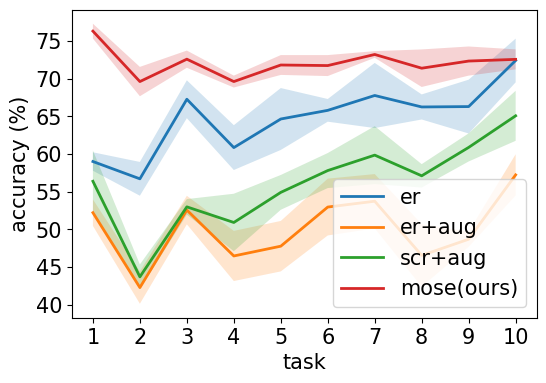

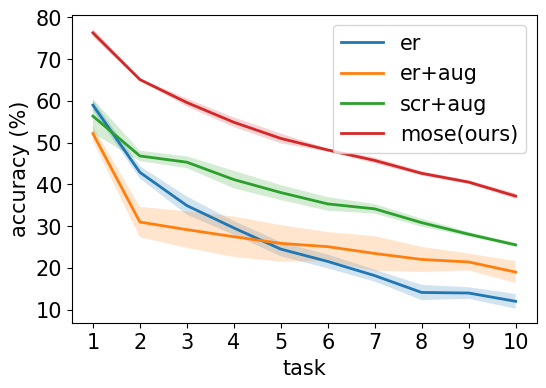

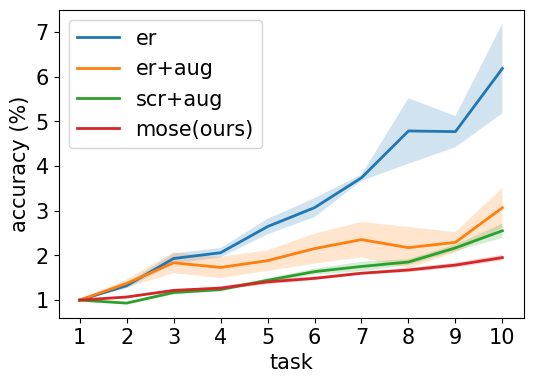

In [31]:
plot_acc_last_epoch(e=1)
plot_acc_avg_epoch(e=1)
plot_acc_over_avg_epoch(e=1)

In [69]:
MEM_SIZES = ['1000', '2000', '5000']
METHODS = ['joint', 'scr', 'er']
AUGMENTATION = ['none', 'ocm']
RUNS = [f"run_{i:02d}" for i in range(4)]
CSV_NAMES = ['buffer_task_accs_table.csv', 'task_accs_table.csv', 'train_last_task_accs_table.csv', 'last_task_accs_table.csv']

In [70]:
base_dir = './outputs'
folders = []
csv_file_paths = []

for root, _, files in os.walk(base_dir, followlinks=True):
    for file in files:
        if file in CSV_NAMES and 'ou run' in root:
            folders.append(root)
            csv_file_path = os.path.join(root, file)
            csv_file_paths.append(csv_file_path)

# 5 * 8 * 4 = 160
print(len(csv_file_paths))
# for i, csv_file_path in enumerate(sorted(csv_file_paths)):
#     print(f"{i}: \t {csv_file_path}")

1272


In [71]:
CSV_DICT = {}
cnt = 0

for mem_size in MEM_SIZES:
    CSV_DICT[mem_size] = {}
    for method in METHODS:
        CSV_DICT[mem_size][method] = {}
        for aug in AUGMENTATION:
            CSV_DICT[mem_size][method][aug] = {}
            for run in RUNS:
                CSV_DICT[mem_size][method][aug][run] = {}
                for csv_name in CSV_NAMES:
                    for folder, csv_file_path in zip(folders, csv_file_paths):
                        if method in folder and mem_size in folder and aug in folder and run in folder and f'/{csv_name}' in csv_file_path:
                            df = pd.read_csv(csv_file_path)
                            CSV_DICT[mem_size][method][aug][run][csv_name] = df
                            # print(csv_file_path)
                            cnt += 1

for mem_size in MEM_SIZES:
    CSV_DICT[mem_size]['mose'] = {}
    CSV_DICT[mem_size]['mose']['ocm'] = {}
    for run in RUNS:
        CSV_DICT[mem_size]['mose']['ocm'][run] = {}
        for csv_name in CSV_NAMES:
            for folder, csv_file_path in zip(folders, csv_file_paths):
                if 'mose' in folder and mem_size in folder and run in folder and f'/{csv_name}' in csv_file_path:
                    df = pd.read_csv(csv_file_path)
                    CSV_DICT[mem_size]['mose']['ocm'][run][csv_name] = df

                    cnt += 1

print(cnt)

288


In [78]:
def buffer_minus_test(mem_size='1000'):

    er_none, er_ocm, scr_ocm, mose, joint_none, joint_ocm = {}, {}, {}, {}, {}, {}

    for run in RUNS:
        er_none[run] = [0. for _ in range(9)]
        er_ocm[run] = [0. for _ in range(9)]
        scr_ocm[run] = [0. for _ in range(9)]
        mose[run] = [0. for _ in range(9)]
        joint_none[run] = [0. for _ in range(9)]
        joint_ocm[run] = [0. for _ in range(9)]

        for j in range(1, 10):
        # j = 9
            train_er_none_df = CSV_DICT[mem_size]['er']['none'][run]['train_last_task_accs_table.csv']
            train_er_ocm_df  = CSV_DICT[mem_size]['er']['ocm'][run]['train_last_task_accs_table.csv']
            train_scr_ocm_df = CSV_DICT[mem_size]['scr']['ocm'][run]['train_last_task_accs_table.csv']
            train_mose_df = CSV_DICT[mem_size]['mose']['ocm'][run]['train_last_task_accs_table.csv']
            train_joint_none_df = CSV_DICT[mem_size]['joint']['none'][run]['train_last_task_accs_table.csv']
            train_joint_ocm_df  = CSV_DICT[mem_size]['joint']['ocm'][run]['train_last_task_accs_table.csv']


            buf_er_none_df = CSV_DICT[mem_size]['er']['none'][run]['buffer_task_accs_table.csv']
            buf_er_ocm_df  = CSV_DICT[mem_size]['er']['ocm'][run]['buffer_task_accs_table.csv']
            buf_scr_ocm_df = CSV_DICT[mem_size]['scr']['ocm'][run]['buffer_task_accs_table.csv']
            buf_mose_df = CSV_DICT[mem_size]['mose']['ocm'][run]['buffer_task_accs_table.csv']
            buf_joint_none_df = CSV_DICT[mem_size]['joint']['none'][run]['buffer_task_accs_table.csv']
            buf_joint_ocm_df  = CSV_DICT[mem_size]['joint']['ocm'][run]['buffer_task_accs_table.csv']

            test_er_none_df = CSV_DICT[mem_size]['er']['none'][run]['task_accs_table.csv']
            test_er_ocm_df  = CSV_DICT[mem_size]['er']['ocm'][run]['task_accs_table.csv']
            test_scr_ocm_df = CSV_DICT[mem_size]['scr']['ocm'][run]['task_accs_table.csv']
            test_mose_df = CSV_DICT[mem_size]['mose']['ocm'][run]['task_accs_table.csv']
            test_joint_none_df = CSV_DICT[mem_size]['joint']['none'][run]['task_accs_table.csv']
            test_joint_ocm_df  = CSV_DICT[mem_size]['joint']['ocm'][run]['task_accs_table.csv']

            for i in range(j):
                test_task_name  = f"task{i}"
                joint_task_name = 'task0'
            # test_task_name = f"task{j}"
            # joint_task_name = 'task0'

                er_none[run][j-1] += (buf_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]) / (j*test_er_none_df.iloc[j][test_task_name])
                er_ocm[run][j-1] += (buf_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]) / (j*test_er_ocm_df.iloc[j][test_task_name])
                scr_ocm[run][j-1] += (buf_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]) / (j*test_scr_ocm_df.iloc[j][test_task_name])
                mose[run][j-1] += (buf_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]) / (j*test_mose_df.iloc[j][test_task_name])
                joint_none[run][j-1] += (buf_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]) / (j*test_joint_none_df.iloc[0][joint_task_name])
                joint_ocm[run][j-1] += (buf_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]) / (j*test_joint_ocm_df.iloc[0][joint_task_name])

                # er_none[run][j-1] += (buf_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]) / (j*buf_er_none_df.iloc[j][test_task_name])
                # er_ocm[run][j-1] += (buf_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]) / (j*buf_er_ocm_df.iloc[j][test_task_name])
                # scr_ocm[run][j-1] += (buf_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]) / (j*buf_scr_ocm_df.iloc[j][test_task_name])
                # mose[run][j-1] += (buf_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]) / (j*buf_mose_df.iloc[j][test_task_name])
                # joint_none[run][j-1] += (buf_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]) / (j*buf_joint_none_df.iloc[0][joint_task_name])
                # joint_ocm[run][j-1] += (buf_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]) / (j*buf_joint_ocm_df.iloc[0][joint_task_name])

                # er_none[run][j-1] += (buf_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]) / j
                # er_ocm[run][j-1] += (buf_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]) / j
                # scr_ocm[run][j-1] += (buf_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]) / j
                # mose[run][j-1] += (buf_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]) / j
                # joint_none[run][j-1] += (buf_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]) / j
                # joint_ocm[run][j-1] += (buf_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]) / j

            # er_none[run][i] += (buf_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]) / (j*buf_er_none_df.iloc[j][test_task_name])
            # er_ocm[run][i] += (buf_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]) / (j*buf_er_ocm_df.iloc[j][test_task_name])
            # scr_ocm[run][i] += (buf_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]) / (j*buf_scr_ocm_df.iloc[j][test_task_name])
            # mose[run][i] += (buf_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]) / (j*buf_mose_df.iloc[j][test_task_name])
            # joint_none[run][i] += (buf_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]) / (j*buf_joint_none_df.iloc[0][joint_task_name])
            # joint_ocm[run][i] += (buf_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]) / (j*buf_joint_ocm_df.iloc[0][joint_task_name])

                # er_none[run][j-1] += (buf_er_none_df.iloc[j][test_task_name]) / j
                # er_ocm[run][j-1] += (buf_er_ocm_df.iloc[j][test_task_name]) / j
                # scr_ocm[run][j-1] += (buf_scr_ocm_df.iloc[j][test_task_name]) / j
                # mose[run][j-1] += (buf_mose_df.iloc[j][test_task_name]) / j
                # joint_none[run][j-1] += (buf_joint_none_df.iloc[0][joint_task_name]) / j
                # joint_ocm[run][j-1] += (buf_joint_ocm_df.iloc[0][joint_task_name]) / j

                # er_none[run][j-1] += (buf_er_none_df.iloc[j][test_task_name] / test_er_none_df.iloc[j][test_task_name]) / j
                # er_ocm[run][j-1] += (buf_er_ocm_df.iloc[j][test_task_name] / test_er_ocm_df.iloc[j][test_task_name]) / j
                # scr_ocm[run][j-1] += (buf_scr_ocm_df.iloc[j][test_task_name] / test_scr_ocm_df.iloc[j][test_task_name]) / j
                # mose[run][j-1] += (buf_mose_df.iloc[j][test_task_name] / test_mose_df.iloc[j][test_task_name]) / j
                # joint_none[run][j-1] += (buf_joint_none_df.iloc[0][joint_task_name] / test_joint_none_df.iloc[0][joint_task_name]) / j
                # joint_ocm[run][j-1] += (buf_joint_ocm_df.iloc[0][joint_task_name] / test_joint_ocm_df.iloc[0][joint_task_name]) / j

            # er_none[run][j-1] += (test_er_none_df.iloc[j][test_task_name]) / j
            # er_ocm[run][j-1] += (test_er_ocm_df.iloc[j][test_task_name]) / j
            # scr_ocm[run][j-1] += (test_scr_ocm_df.iloc[j][test_task_name]) / j
            # mose[run][j-1] += (test_mose_df.iloc[j][test_task_name]) / j
            # joint_none[run][j-1] += (test_joint_none_df.iloc[0][joint_task_name]) / j
            # joint_ocm[run][j-1] += (test_joint_ocm_df.iloc[0][joint_task_name]) / j

            # er_none[run][j-1] += (test_er_none_df.iloc[j][test_task_name])
            # er_ocm[run][j-1] += (test_er_ocm_df.iloc[j][test_task_name])
            # scr_ocm[run][j-1] += (test_scr_ocm_df.iloc[j][test_task_name])
            # mose[run][j-1] += (test_mose_df.iloc[j][test_task_name])
            # joint_none[run][j-1] += (test_joint_none_df.iloc[0][joint_task_name])
            # joint_ocm[run][j-1] += (test_joint_ocm_df.iloc[0][joint_task_name])

                # er_none[run][j-1] += (buf_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]) / (buf_er_none_df.iloc[j][test_task_name]+test_er_none_df.iloc[j][test_task_name]) / j
                # er_ocm[run][j-1] += (buf_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]) / (buf_er_ocm_df.iloc[j][test_task_name]+test_er_ocm_df.iloc[j][test_task_name]) / j
                # scr_ocm[run][j-1] += (buf_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]) / (buf_scr_ocm_df.iloc[j][test_task_name]+test_scr_ocm_df.iloc[j][test_task_name]) / j
                # mose[run][j-1] += (buf_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]) / (buf_mose_df.iloc[j][test_task_name]+test_mose_df.iloc[j][test_task_name]) / j
                # joint_none[run][j-1] += (buf_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]) / (buf_joint_none_df.iloc[0][joint_task_name]+test_joint_none_df.iloc[0][joint_task_name]) / j
                # joint_ocm[run][j-1] += (buf_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]) / (buf_joint_ocm_df.iloc[0][joint_task_name]+test_joint_ocm_df.iloc[0][joint_task_name]) / j

            # er_none[run][i] += (buf_er_none_df.iloc[j][test_task_name]-train_er_none_df.iloc[i][test_task_name])
            # er_ocm[run][i] += (buf_er_ocm_df.iloc[j][test_task_name]-train_er_ocm_df.iloc[i][test_task_name])
            # scr_ocm[run][i] += (buf_scr_ocm_df.iloc[j][test_task_name]-train_scr_ocm_df.iloc[i][test_task_name])
            # mose[run][i] += (buf_mose_df.iloc[j][test_task_name]-train_mose_df.iloc[i][test_task_name])


                

    er_none_mean = np.mean([er_none[run] for run in RUNS], axis=0)
    er_none_std = np.std([er_none[run] for run in RUNS], axis=0)
    er_ocm_mean = np.mean([er_ocm[run] for run in RUNS], axis=0)
    er_ocm_std = np.std([er_ocm[run] for run in RUNS], axis=0)
    scr_ocm_mean = np.mean([scr_ocm[run] for run in RUNS], axis=0)
    scr_ocm_std = np.std([scr_ocm[run] for run in RUNS], axis=0)
    mose_mean = np.mean([mose[run] for run in RUNS], axis=0)
    mose_std = np.std([mose[run] for run in RUNS], axis=0)
    joint_none_mean = np.mean([joint_none[run] for run in RUNS], axis=0)
    joint_none_std = np.std([joint_none[run] for run in RUNS], axis=0)
    joint_ocm_mean = np.mean([joint_ocm[run] for run in RUNS], axis=0)
    joint_ocm_std = np.std([joint_ocm[run] for run in RUNS], axis=0)

    figure = plt.figure(figsize=(6,5))
    x = np.arange(2, 11)
    plt.plot(x, er_none_mean, linewidth=2.0,  label='er')
    plt.plot(x, er_ocm_mean,  linewidth=2.0, label='er+aug')
    plt.plot(x, scr_ocm_mean, linewidth=2.0, label='scr+aug')
    plt.plot(x, mose_mean,    linewidth=2.0, label='mose(ours)')
    # plt.plot(x, joint_none_mean, linewidth=2.0,  label='joint')
    # plt.plot(x, joint_ocm_mean,  linewidth=2.0, label='joint+aug')

    plt.fill_between(x, er_none_mean-er_none_std, er_none_mean+er_none_std, alpha=0.2)
    plt.fill_between(x, er_ocm_mean-er_ocm_std, er_ocm_mean+er_ocm_std, alpha=0.2)
    plt.fill_between(x, scr_ocm_mean-scr_ocm_std, scr_ocm_mean+scr_ocm_std, alpha=0.2)
    plt.fill_between(x, mose_mean-mose_std, mose_mean+mose_std, alpha=0.2)
    # plt.fill_between(x, joint_none_mean-joint_none_std, joint_none_mean+joint_none_std, alpha=0.2)
    # plt.fill_between(x, joint_ocm_mean-joint_ocm_std, joint_ocm_mean+joint_ocm_std, alpha=0.2)

    plt.xlabel('task', fontdict={'size' : 18})
    # plt.ylabel('test accuracy (%)', fontdict={'size' : 18})
    plt.ylabel('BOF', fontdict={'size' : 18})
    plt.xticks(x, size= 18)
    plt.yticks(size= 18)
    plt.legend(loc='best', fontsize=15, fancybox=True)
    plt.show()

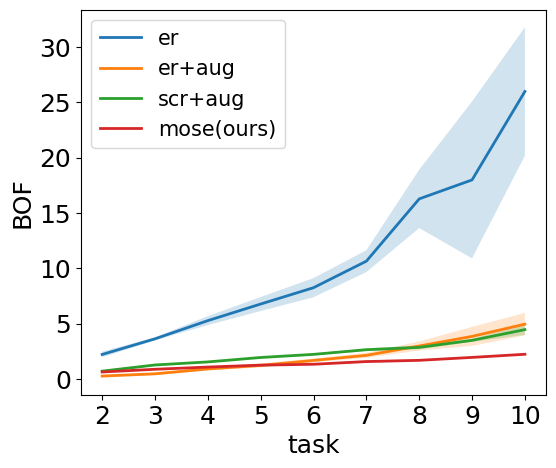

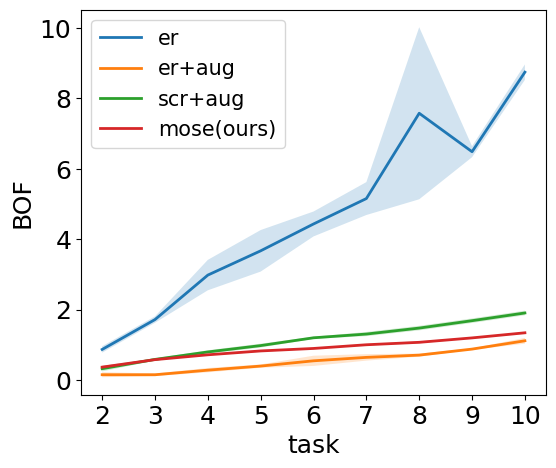

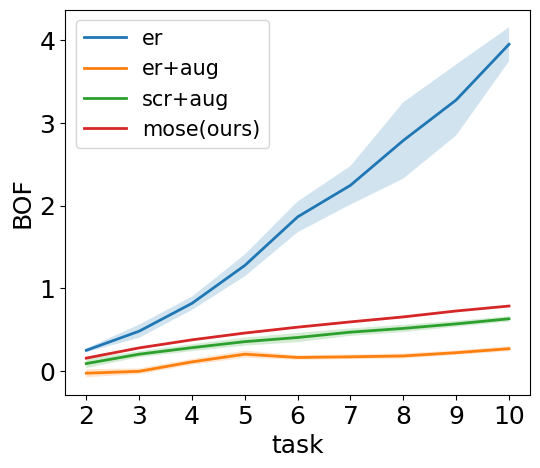

In [79]:
buffer_minus_test('1000')
buffer_minus_test('2000')
buffer_minus_test('5000')

In [104]:
def train_minus_test(mem_size='1000'):

    er_none, er_ocm, scr_ocm, mose, joint_none, joint_ocm = {}, {}, {}, {}, {}, {}

    for run in RUNS:
        er_none[run] = [0. for _ in range(10)]
        er_ocm[run] = [0. for _ in range(10)]
        scr_ocm[run] = [0. for _ in range(10)]
        mose[run] = [0. for _ in range(10)]
        joint_none[run] = [0. for _ in range(10)]
        joint_ocm[run] = [0. for _ in range(10)]

        for j in range(10):
            train_er_none_df = CSV_DICT[mem_size]['er']['none'][run]['train_last_task_accs_table.csv']
            train_er_ocm_df  = CSV_DICT[mem_size]['er']['ocm'][run]['train_last_task_accs_table.csv']
            train_scr_ocm_df = CSV_DICT[mem_size]['scr']['ocm'][run]['train_last_task_accs_table.csv']
            train_mose_df = CSV_DICT[mem_size]['mose']['ocm'][run]['train_last_task_accs_table.csv']
            train_joint_none_df = CSV_DICT[mem_size]['joint']['none'][run]['train_last_task_accs_table.csv']
            train_joint_ocm_df  = CSV_DICT[mem_size]['joint']['ocm'][run]['train_last_task_accs_table.csv']

            test_er_none_df = CSV_DICT[mem_size]['er']['none'][run]['task_accs_table.csv']
            test_er_ocm_df  = CSV_DICT[mem_size]['er']['ocm'][run]['task_accs_table.csv']
            test_scr_ocm_df = CSV_DICT[mem_size]['scr']['ocm'][run]['task_accs_table.csv']
            test_mose_df = CSV_DICT[mem_size]['mose']['ocm'][run]['task_accs_table.csv']
            test_joint_none_df = CSV_DICT[mem_size]['joint']['none'][run]['task_accs_table.csv']
            test_joint_ocm_df  = CSV_DICT[mem_size]['joint']['ocm'][run]['task_accs_table.csv']

            test_task_name  = f"task{j}"
            joint_task_name = 'task0'

            # er_none[run][j] += (train_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]) / (test_er_none_df.iloc[j][test_task_name])
            # er_ocm[run][j] += (train_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]) / (test_er_ocm_df.iloc[j][test_task_name])
            # scr_ocm[run][j] += (train_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]) / (test_scr_ocm_df.iloc[j][test_task_name])
            # mose[run][j] += (train_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]) / (test_mose_df.iloc[j][test_task_name])
            # joint_none[run][j] += (train_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]) / (test_joint_none_df.iloc[0][joint_task_name])
            # joint_ocm[run][j] += (train_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]) / (test_joint_ocm_df.iloc[0][joint_task_name])

            # er_none[run][j] += (train_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]) / (train_er_none_df.iloc[j][test_task_name])
            # er_ocm[run][j] += (train_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]) / (train_er_ocm_df.iloc[j][test_task_name])
            # scr_ocm[run][j] += (train_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]) / (train_scr_ocm_df.iloc[j][test_task_name])
            # mose[run][j] += (train_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]) / (train_mose_df.iloc[j][test_task_name])
            # joint_none[run][j] += (train_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]) / (train_joint_none_df.iloc[0][joint_task_name])
            # joint_ocm[run][j] += (train_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]) / (train_joint_ocm_df.iloc[0][joint_task_name])

            er_none[run][j] += train_er_none_df.iloc[j][test_task_name]-test_er_none_df.iloc[j][test_task_name]
            er_ocm[run][j] += train_er_ocm_df.iloc[j][test_task_name]-test_er_ocm_df.iloc[j][test_task_name]
            scr_ocm[run][j] += train_scr_ocm_df.iloc[j][test_task_name]-test_scr_ocm_df.iloc[j][test_task_name]
            mose[run][j] += train_mose_df.iloc[j][test_task_name]-test_mose_df.iloc[j][test_task_name]
            joint_none[run][j] += train_joint_none_df.iloc[0][joint_task_name]-test_joint_none_df.iloc[0][joint_task_name]
            joint_ocm[run][j] += train_joint_ocm_df.iloc[0][joint_task_name]-test_joint_ocm_df.iloc[0][joint_task_name]

            # er_none[run][j] += train_er_none_df.iloc[j][test_task_name]
            # er_ocm[run][j] += train_er_ocm_df.iloc[j][test_task_name]
            # scr_ocm[run][j] += train_scr_ocm_df.iloc[j][test_task_name]
            # mose[run][j] += train_mose_df.iloc[j][test_task_name]
            # joint_none[run][j] += train_joint_none_df.iloc[0][joint_task_name]
            # joint_ocm[run][j] += train_joint_ocm_df.iloc[0][joint_task_name]

            # er_none[run][j] += test_er_none_df.iloc[j][test_task_name]
            # er_ocm[run][j] += test_er_ocm_df.iloc[j][test_task_name]
            # scr_ocm[run][j] += test_scr_ocm_df.iloc[j][test_task_name]
            # mose[run][j] += test_mose_df.iloc[j][test_task_name]
            # joint_none[run][j] += test_joint_none_df.iloc[0][joint_task_name]
            # joint_ocm[run][j] += test_joint_ocm_df.iloc[0][joint_task_name]

    er_none_mean = np.mean([er_none[run] for run in RUNS], axis=0)
    er_none_std = np.std([er_none[run] for run in RUNS], axis=0)
    er_ocm_mean = np.mean([er_ocm[run] for run in RUNS], axis=0)
    er_ocm_std = np.std([er_ocm[run] for run in RUNS], axis=0)
    scr_ocm_mean = np.mean([scr_ocm[run] for run in RUNS], axis=0)
    scr_ocm_std = np.std([scr_ocm[run] for run in RUNS], axis=0)
    mose_mean = np.mean([mose[run] for run in RUNS], axis=0)
    mose_std = np.std([mose[run] for run in RUNS], axis=0)
    joint_none_mean = np.mean([joint_none[run] for run in RUNS], axis=0)
    joint_none_std = np.std([joint_none[run] for run in RUNS], axis=0)
    joint_ocm_mean = np.mean([joint_ocm[run] for run in RUNS], axis=0)
    joint_ocm_std = np.std([joint_ocm[run] for run in RUNS], axis=0)

    figure = plt.figure(figsize=(6,4))
    x = np.arange(1, 10+1)
    plt.plot(x, er_none_mean, linewidth=2.0,  label='er')
    plt.plot(x, er_ocm_mean,  linewidth=2.0, label='er+aug')
    plt.plot(x, scr_ocm_mean, linewidth=2.0, label='scr+aug')
    plt.plot(x, mose_mean,    linewidth=2.0, label='mose(ours)')
    # plt.plot(x, joint_none_mean, linewidth=2.0,  label='joint')
    # plt.plot(x, joint_ocm_mean,  linewidth=2.0, label='joint+aug')

    plt.fill_between(x, er_none_mean-er_none_std, er_none_mean+er_none_std, alpha=0.2)
    plt.fill_between(x, er_ocm_mean-er_ocm_std, er_ocm_mean+er_ocm_std, alpha=0.2)
    plt.fill_between(x, scr_ocm_mean-scr_ocm_std, scr_ocm_mean+scr_ocm_std, alpha=0.2)
    plt.fill_between(x, mose_mean-mose_std, mose_mean+mose_std, alpha=0.2)
    # plt.fill_between(x, joint_none_mean-joint_none_std, joint_none_mean+joint_none_std, alpha=0.2)
    # plt.fill_between(x, joint_ocm_mean-joint_ocm_std, joint_ocm_mean+joint_ocm_std, alpha=0.2)

    plt.xlabel('task', fontdict={'size' : 15})
    plt.ylabel('accuracy (%)', fontdict={'size' : 15})
    plt.xticks(x, size= 15)
    plt.yticks(size= 15)
    plt.legend(loc='best', fontsize=15, fancybox=True)
    plt.show()

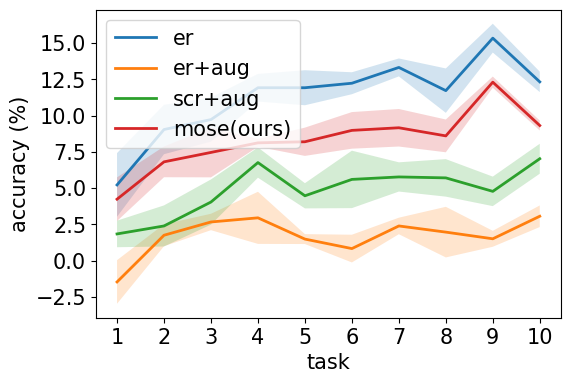

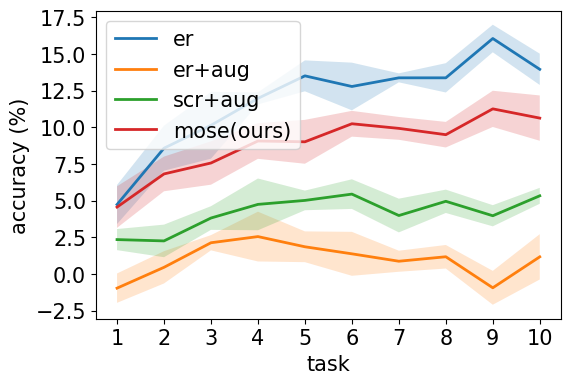

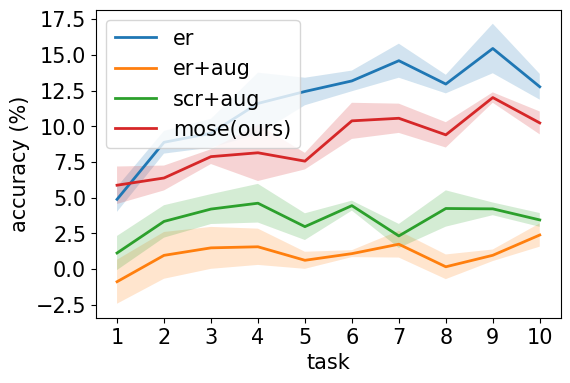

In [105]:
train_minus_test('1000')
train_minus_test('2000')
train_minus_test('5000')

In [81]:
MEM_SIZES = ['1000']
METHODS = ['buf']
AUGMENTATION = ['none', 'ocm']
RUNS = [f"run_{i:02d}" for i in range(5)]
EPOCHS = [f'epoch{i} ' for i in range(1, 11)]
CSV_NAMES = ['buffer_task_accs_table.csv', 'task_accs_table.csv', 'train_last_task_accs_table.csv', 'last_task_accs_table.csv']


In [82]:
base_dir = './outputs'
folders = []
csv_file_paths = []

for root, _, files in os.walk(base_dir, followlinks=True):
    for file in files:
        if file in CSV_NAMES and 'ou run_' in root and 'buf' in root:
            folders.append(root)
            csv_file_path = os.path.join(root, file)
            csv_file_paths.append(csv_file_path)

print(len(csv_file_paths))
# for i, csv_file_path in enumerate(sorted(csv_file_paths)):
#     print(f"{i}: \t {csv_file_path}")

908


In [83]:
CSV_DICT = {}
cnt = 0

for epoch in EPOCHS:
    CSV_DICT[epoch] = {}
    for mem_size in MEM_SIZES:
        CSV_DICT[epoch][mem_size] = {}
        for aug in AUGMENTATION:
            CSV_DICT[epoch][mem_size][aug] = {}
            for run in RUNS:
                CSV_DICT[epoch][mem_size][aug][run] = {}
                for csv_name in CSV_NAMES:
                    for folder, csv_file_path in zip(folders, csv_file_paths):
                            if 'buf' in folder and mem_size in folder and aug in folder and run in folder and epoch in folder and f'/{csv_name}' in csv_file_path:
                                df = pd.read_csv(csv_file_path)
                                CSV_DICT[epoch][mem_size][aug][run][csv_name] = df
                                # print(csv_file_path)
                                cnt += 1


print(cnt)

428


In [84]:
print(CSV_DICT['epoch5 ']['1000']['ocm']['run_04']['task_accs_table.csv'])

  Unnamed: 0  task0  task1  task2  task3  task4  task5  task6  task7  task8  \
0      task0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      task1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2      task2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3      task3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4      task4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5      task5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6      task6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7      task7    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8      task8    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9      task9   14.2   11.9   10.7    5.9    9.7   18.1   15.3   10.8   14.2   

   task9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9   10.5  


In [90]:
def buffer_minus_test(mem_size='1000'):

    buf_none = {epoch : {} for epoch in EPOCHS}
    buf_ocm = {epoch : {} for epoch in EPOCHS}

    buf_none_mean = []
    buf_none_std = []
    buf_none_min = []
    buf_none_max = []

    buf_ocm_mean = []
    buf_ocm_std = []
    buf_ocm_min = []
    buf_ocm_max = []

    for epoch in EPOCHS:
        for run in RUNS:
            buf_none[epoch][run] = 0.
            buf_ocm[epoch][run]  = 0.

            buf_none_df_buffer = CSV_DICT[epoch][mem_size]['none'][run]['buffer_task_accs_table.csv']
            buf_ocm_df_buffer  = CSV_DICT[epoch][mem_size]['ocm'][run]['buffer_task_accs_table.csv']

            buf_none_df_test = CSV_DICT[epoch][mem_size]['none'][run]['task_accs_table.csv']
            buf_ocm_df_test  = CSV_DICT[epoch][mem_size]['ocm'][run]['task_accs_table.csv']

            for i in range(9):
                test_task_name  = f"task{i}"

                buf_none[epoch][run] += (buf_none_df_buffer.iloc[9][test_task_name]-buf_none_df_test.iloc[9][test_task_name]) / (9 * buf_none_df_test.iloc[9][test_task_name])
                buf_ocm[epoch][run] += (buf_ocm_df_buffer.iloc[9][test_task_name]-buf_ocm_df_test.iloc[9][test_task_name]) / (9 * buf_ocm_df_test.iloc[9][test_task_name])

                # buf_none[epoch][run] += (buf_none_df_buffer.iloc[9][test_task_name]-buf_none_df_test.iloc[9][test_task_name]) / (9)
                # buf_ocm[epoch][run] += (buf_ocm_df_buffer.iloc[9][test_task_name]-buf_ocm_df_test.iloc[9][test_task_name]) / (9)

                # buf_none[epoch][run] += (buf_none_df_buffer.iloc[9][test_task_name] )/9
                # buf_ocm[epoch][run] += (buf_ocm_df_buffer.iloc[9][test_task_name] )/9

                # buf_none[epoch][run] += (buf_none_df_test.iloc[9][test_task_name]) / 9
                # buf_ocm[epoch][run] += (buf_ocm_df_test.iloc[9][test_task_name]) / 9

        buf_none_mean.append(np.mean([buf_none[epoch][run] for run in RUNS]))
        buf_none_std.append(np.std([buf_none[epoch][run] for run in RUNS]))
        buf_none_min.append(np.min([buf_none[epoch][run] for run in RUNS]))
        buf_none_max.append(np.max([buf_none[epoch][run] for run in RUNS]))

        buf_ocm_mean.append(np.mean([buf_ocm[epoch][run] for run in RUNS]))
        buf_ocm_std.append(np.std([buf_ocm[epoch][run] for run in RUNS]))
        buf_ocm_min.append(np.min([buf_ocm[epoch][run] for run in RUNS]))
        buf_ocm_max.append(np.max([buf_ocm[epoch][run] for run in RUNS]))

    buf_none_mean = np.array(buf_none_mean)
    buf_none_std = np.array(buf_none_std)
    buf_ocm_mean = np.array(buf_ocm_mean)
    buf_ocm_std = np.array(buf_ocm_std)

    figure = plt.figure(figsize=(6,5))
    x = np.arange(1, 11)
    plt.plot(x, buf_none_mean, color='brown', linewidth=2.0,  label='joint')
    plt.plot(x, buf_ocm_mean, color='purple', linewidth=2.0, label='joint+aug')

    # plt.fill_between(x, buf_none_mean-buf_none_std, buf_none_mean+buf_none_std, color='brown', alpha=0.2)
    plt.fill_between(x, buf_none_mean-buf_none_std, buf_none_max, color='brown', alpha=0.2)
    # plt.fill_between(x, buf_none_min, buf_none_max, color='brown', alpha=0.2)
    plt.fill_between(x, buf_ocm_mean-buf_ocm_std, buf_ocm_mean+buf_ocm_std, color='purple', alpha=0.2)
    # plt.fill_between(x, buf_ocm_min, buf_ocm_max, color='purple', alpha=0.2)

    plt.xlabel('epoch', fontdict={'size' : 18})
    plt.ylabel('BOF', fontdict={'size' : 18})
    plt.xticks(x, size= 18)
    plt.yticks(size= 18)
    plt.legend(loc='best', fontsize=18, fancybox=True)
    plt.show()

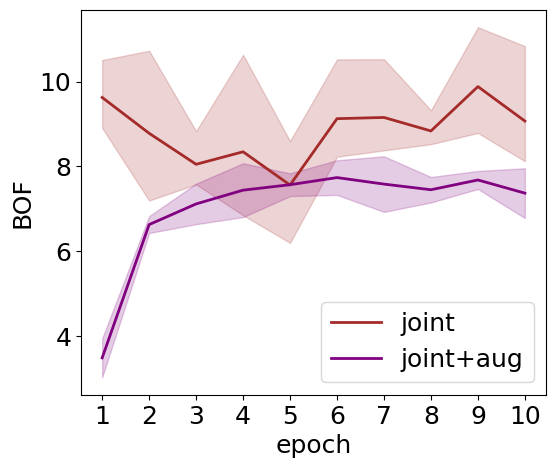

In [91]:
buffer_minus_test(mem_size='1000')

In [87]:
def train_minus_test(mem_size='1000'):

    buf_none = {epoch : 0. for epoch in EPOCHS}
    buf_ocm = {epoch : 0. for epoch in EPOCHS}

    for epoch in EPOCHS:

        buf_none_df_train = CSV_DICT[epoch][mem_size]['none'][run]['train_last_task_accs_table.csv']
        buf_ocm_df_train  = CSV_DICT[epoch][mem_size]['ocm'][run]['train_last_task_accs_table.csv']

        buf_none_df_test = CSV_DICT[epoch][mem_size]['none'][run]['task_accs_table.csv']
        buf_ocm_df_test  = CSV_DICT[epoch][mem_size]['ocm'][run]['task_accs_table.csv']

        test_task_name  = f"task{9}"

        buf_none[epoch] += (buf_none_df_train.iloc[9][test_task_name]-buf_none_df_test.iloc[9][test_task_name])
        buf_ocm[epoch] += (buf_ocm_df_train.iloc[9][test_task_name]-buf_ocm_df_test.iloc[9][test_task_name])

        # buf_none[epoch] += (buf_none_df_train.iloc[9][test_task_name])
        # buf_ocm[epoch] += (buf_ocm_df_train.iloc[9][test_task_name])

        # buf_none[epoch] += (buf_none_df_test.iloc[9][test_task_name])
        # buf_ocm[epoch] += (buf_ocm_df_test.iloc[9][test_task_name])

    print(buf_none)
    print(buf_ocm)


    figure = plt.figure(figsize=(6,4))
    x = np.arange(1, 11)
    plt.plot(x, buf_none.values(), linewidth=2.0,  label='joint')
    plt.plot(x, buf_ocm.values(),  linewidth=2.0, label='joint+aug')

    # plt.fill_between(x, buf_none_mean-buf_none_std, buf_none_mean+buf_none_std, alpha=0.2)
    # plt.fill_between(x, buf_ocm_mean-buf_ocm_std, buf_ocm_mean+buf_ocm_std, alpha=0.2)

    plt.xlabel('epoch', fontdict={'size' : 15})
    plt.ylabel('accuracy (%)', fontdict={'size' : 15})
    plt.xticks(x, size= 15)
    plt.yticks(size= 15)
    plt.legend(loc='best', fontsize=15, fancybox=True)
    plt.show()